In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Цель: по двум дням определить, сможет ли пользователь продолжить курс. Для каждого студента предсказать вероятность, что он наберет более 40 баллов за курс. Предсказания с id пользователя сохранить в файл csv

# Предобработка данных

В submissions у нас есть информация по каждому user_id и step_id, timestamp и submission_status(correct или wrong) действия. В events у нас есть информация по каждому user_id и step_id, timestamp и action (viewed, passed, discovered)

In [3]:
events_data_train = pd.read_csv(r"C:\Users\user\PycharmProjects\stepic_user_data_analysis\data_analysis\event_data_train.csv")
events_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data_train = pd.read_csv(r"C:\Users\user\PycharmProjects\stepic_user_data_analysis\data_analysis\submissions_data_train.csv")
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Преобразуем timestamp в дату и день 

In [6]:
submissions_data_train['date'] = pd.to_datetime(submissions_data_train.timestamp, unit='s')
submissions_data_train['day'] = submissions_data_train.date.dt.date
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Создадим сводную таблицу с количеством правильных и неправильных попыток каждого пользователя

In [7]:
users_scores = submissions_data_train.pivot_table(index='user_id',
                                            columns='submission_status',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()

users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Сделаем аналогичные действия с events_data_train

In [9]:
events_data_train['date'] = pd.to_datetime(events_data_train.timestamp, unit='s')
events_data_train['day'] = events_data_train.date.dt.date
events_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [10]:
users_events_data = events_data_train.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Создадим users_data, куда будем добавлять всю преобразованную информацию по пользователям

In [11]:
users_data = events_data_train.groupby('user_id', as_index=False).agg({'timestamp': 'max'})\
.rename(columns={'timestamp': 'last_timestamp'})

users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [12]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data = users_data.merge(users_events_data, how='outer')

users_data.head()

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,0.0,0.0,1,0,0,1
1,2,1519226966,2.0,0.0,9,9,2,10
2,3,1444581588,29.0,23.0,91,87,30,192
3,5,1499859939,2.0,2.0,11,11,4,12
4,7,1521634660,0.0,0.0,1,1,0,1


Создадим users_days с подсчетом уникальных дней пользователя

In [14]:
users_days = events_data_train.groupby('user_id').day.nunique().to_frame().reset_index()
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [15]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,0.0,0.0,1,0,0,1,1
1,2,1519226966,2.0,0.0,9,9,2,10,2
2,3,1444581588,29.0,23.0,91,87,30,192,7
3,5,1499859939,2.0,2.0,11,11,4,12,2
4,7,1521634660,0.0,0.0,1,1,0,1,1


Создадим целевую переменную passed_course 

In [16]:
users_data['passed_course'] = users_data.passed > 40
users_data

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,29.0,23.0,91,87,30,192,7,True
3,5,1499859939,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,33.0,9.0,69,69,34,180,9,True
19232,26797,1509995096,2.0,0.0,10,10,2,13,2,False


Посчитаем для каждого пользователя его min_timestamp - когда он начал проходить курс

In [17]:
user_min_time = (events_data_train.groupby('user_id', as_index=False).agg({'timestamp': 'min'})
                 .rename({'timestamp': 'min_timestamp'}, axis=1))
users_data = users_data.merge(user_min_time, how='outer')
users_data

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,33.0,9.0,69,69,34,180,9,True,1495287049
19232,26797,1509995096,2.0,0.0,10,10,2,13,2,False,1508425316


Создадим колонку user_time с id и timestamp каждого действия пользователя

In [18]:
events_data_train['user_time'] = (events_data_train.user_id.map(str) + '_' + events_data_train.timestamp.map(str))

events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


Добавим временной порог 2 дня, так как будем обучать модель только по первым двум дням

In [20]:
learning_time_threshold = 2 * 24 * 60 * 60
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + \
                               (user_min_time.min_timestamp
                                + learning_time_threshold).map(str)
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

user_min_time

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473000264
1,2,1514383364,2_1514556164
2,3,1434358476,3_1434531276
3,5,1466156809,5_1466329609
4,7,1521634660,7_1521807460
...,...,...,...
19229,26790,1451484016,26790_1451656816
19230,26793,1510225031,26793_1510397831
19231,26794,1495287049,26794_1495459849
19232,26797,1508425316,26797_1508598116


In [22]:
events_data_train = events_data_train.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648


Отберем в events_data только данные по первым двум дням

In [24]:
events_data = events_data_train[events_data_train.user_time <= events_data_train.user_learning_time_threshold]

events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648


Проведем аналогичные действия с submissions_data_train

In [25]:
submissions_data_train['users_time'] = (submissions_data_train.user_id.map(str) + '_' +
                                  submissions_data_train.timestamp.map(str))
submissions_data_train = submissions_data_train.merge(user_min_time[['user_id',
                                                         'user_learning_time_threshold']],
                                          how='outer')
submissions_data = submissions_data_train[submissions_data_train.users_time <=
                                          submissions_data_train.user_learning_time_threshold]

submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434518777
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434518777


Наконец, соберем датасет с признаками

In [26]:
X = submissions_data.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns={'day': 'days'})

X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2


In [27]:
steps_tried = submissions_data.groupby('user_id').step_id\
    .nunique().to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})

steps_tried

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,18
...,...,...
8810,26786,1
8811,26787,3
8812,26794,22
8813,26797,2


In [28]:
X = X.merge(steps_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,2,18


In [29]:
users_scores = submissions_data.pivot_table(index='user_id',
                                                  columns='submission_status',
                                                  values='step_id',
                                                  aggfunc='count',
                                                  fill_value=0).reset_index()

users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,18,23
...,...,...,...
8810,26786,1,0
8811,26787,3,0
8812,26794,24,7
8813,26797,2,0


In [31]:
X = X.merge(users_scores)
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,2,18,18,23
...,...,...,...,...,...
8810,26786,1,1,1,0
8811,26787,1,3,3,0
8812,26794,2,22,24,7
8813,26797,1,2,2,0


In [33]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,2,18,18,23,0.439024
...,...,...,...,...,...,...
8810,26786,1,1,1,0,1.000000
8811,26787,1,3,3,0,1.000000
8812,26794,2,22,24,7,0.774194
8813,26797,1,2,2,0,1.000000


In [34]:
X = X.merge(events_data.pivot_table(index='user_id',
                                          columns='action',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0)\
            .reset_index()[['user_id', 'viewed']], how='outer')

X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,4.0,4.0,0.500000,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,2.0,18.0,18.0,23.0,0.439024,117
...,...,...,...,...,...,...,...
19229,26781,NaN,NaN,NaN,NaN,NaN,6
19230,26788,NaN,NaN,NaN,NaN,NaN,1
19231,26789,NaN,NaN,NaN,NaN,NaN,2
19232,26790,NaN,NaN,NaN,NaN,NaN,2


In [35]:
X = X.fillna(0)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,4.0,4.0,0.500000,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,2.0,18.0,18.0,23.0,0.439024,117
...,...,...,...,...,...,...,...
19229,26781,0.0,0.0,0.0,0.0,0.000000,6
19230,26788,0.0,0.0,0.0,0.0,0.000000,1
19231,26789,0.0,0.0,0.0,0.0,0.000000,2
19232,26790,0.0,0.0,0.0,0.0,0.000000,2


In [37]:
X = X.merge(users_data[['user_id', 'passed_course']], how='outer')
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course
0,2,1.0,2.0,2.0,0.0,1.000000,9,False
1,3,1.0,4.0,4.0,4.0,0.500000,20,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False
4,16,2.0,18.0,18.0,23.0,0.439024,117,True
...,...,...,...,...,...,...,...,...
19229,26781,0.0,0.0,0.0,0.0,0.000000,6,True
19230,26788,0.0,0.0,0.0,0.0,0.000000,1,False
19231,26789,0.0,0.0,0.0,0.0,0.000000,2,False
19232,26790,0.0,0.0,0.0,0.0,0.000000,2,False


In [38]:
y = X.passed_course.map(int)
y

0        0
1        1
2        1
3        0
4        1
        ..
19229    1
19230    0
19231    0
19232    0
19233    0
Name: passed_course, Length: 19234, dtype: int64

In [39]:
X = X.drop(['passed_course'], axis=1)

In [40]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,4.0,4.0,0.500000,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,2.0,18.0,18.0,23.0,0.439024,117


Разобъем данные на тренировочный и валидационный датасет

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей

Протестируем как работает модель Random Forest с подбором гиперпараметров

In [42]:
clf_rf = RandomForestClassifier(random_state=123)

parameters = {'n_estimators': [100, 150, 200],
              'max_features': [None, 'sqrt', 'log2'],
              'max_depth': range(1, 10, 1),
              'min_samples_split': [2, 6, 10],
              'min_samples_leaf': [1, 3, 4],
              'bootstrap': [True, False]}

In [43]:
forest_CV = RandomizedSearchCV(clf_rf, parameters, cv=5, random_state=23, scoring='roc_auc', n_iter=15)

In [44]:
forest_CV.fit(X_train, y_train)
print(forest_CV.best_params_)
print(forest_CV.best_score_)

{'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 6, 'bootstrap': True}
0.8715598736048487


In [45]:
forest_proba_train = forest_CV.predict_proba(X_train)[:, 1]
forest_proba_test = forest_CV.predict_proba(X_test)[:, 1]

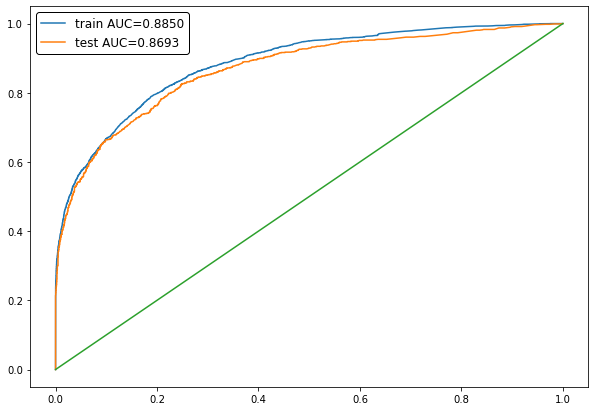

In [46]:
train_auc = roc_auc_score(y_train, forest_proba_train)
test_auc = roc_auc_score(y_test, forest_proba_test)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train,forest_proba_train)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, forest_proba_test)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

Попробуем модель логичестической регрессии

In [47]:
params_new = {'C': [100, 10, 1, 0.1, 0.01, 0.001]}

grid_search_log_res = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), params_new, cv=5, scoring='roc_auc')
grid_search_log_res.fit(X_train, y_train)

new_proba_train = grid_search_log_res.predict_proba(X_train)[:, 1]
new_proba_test = grid_search_log_res.predict_proba(X_test)[:, 1]

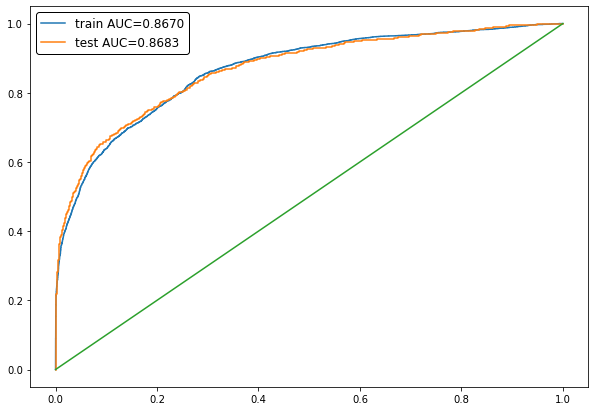

In [48]:
train_auc = roc_auc_score(y_train, new_proba_train)
test_auc = roc_auc_score(y_test, new_proba_test)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, new_proba_train)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, new_proba_test)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

Результат немного хуже, чем Random forest

Применим градиентный бустинг, для catboost нет категориальных переменных, но ради эксперимента ее тоже попробуем

In [49]:
import xgboost

In [50]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

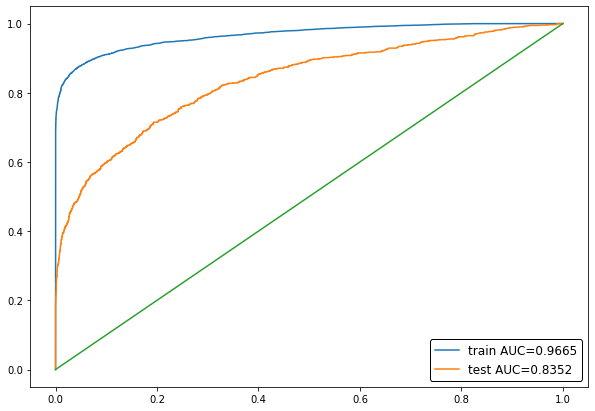

In [51]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

Для тренировочной выборке результат почти идеальный, но на тестовой значительно хуже, чем прошлые модели

In [52]:
import catboost

In [53]:
boosting_model_new = catboost.CatBoostClassifier(n_estimators=200)

boosting_model_new.fit(X_train, y_train)

y_train_predicted_new = boosting_model_new.predict_proba(X_train)[:, 1]
y_test_predicted_new = boosting_model_new.predict_proba(X_test)[:, 1]

Learning rate set to 0.144812
0:	learn: 0.5845438	total: 189ms	remaining: 37.6s
1:	learn: 0.5103234	total: 199ms	remaining: 19.7s
2:	learn: 0.4609148	total: 206ms	remaining: 13.5s
3:	learn: 0.4301717	total: 212ms	remaining: 10.4s
4:	learn: 0.4084957	total: 218ms	remaining: 8.48s
5:	learn: 0.3923649	total: 223ms	remaining: 7.21s
6:	learn: 0.3795667	total: 228ms	remaining: 6.28s
7:	learn: 0.3715209	total: 233ms	remaining: 5.59s
8:	learn: 0.3668124	total: 238ms	remaining: 5.05s
9:	learn: 0.3633532	total: 243ms	remaining: 4.61s
10:	learn: 0.3602115	total: 248ms	remaining: 4.25s
11:	learn: 0.3572260	total: 252ms	remaining: 3.95s
12:	learn: 0.3553098	total: 257ms	remaining: 3.7s
13:	learn: 0.3547345	total: 260ms	remaining: 3.46s
14:	learn: 0.3529110	total: 265ms	remaining: 3.27s
15:	learn: 0.3513842	total: 269ms	remaining: 3.1s
16:	learn: 0.3503863	total: 274ms	remaining: 2.95s
17:	learn: 0.3495562	total: 279ms	remaining: 2.82s
18:	learn: 0.3489179	total: 284ms	remaining: 2.7s
19:	learn: 0.3

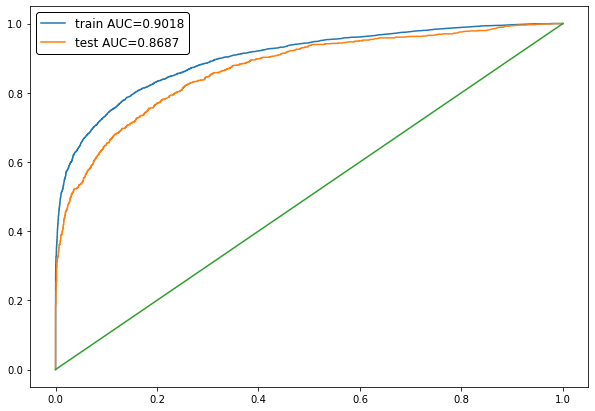

In [54]:
train_auc = roc_auc_score(y_train, y_train_predicted_new)
test_auc = roc_auc_score(y_test, y_test_predicted_new)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted_new)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted_new)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

В качестве лучшей модели возьмем Random_forest

In [57]:
best_model = forest_CV

Аналогично предобработаем тестовые данные, на которых будем делать финальные предсказания, в них уже отобраны данные только по двум первым дням

In [106]:
events_test_data = pd.read_csv(r"C:\Users\user\Downloads\events_data_test.csv")
events_test_data['user_id'].nunique()

6184

In [107]:
submissions_test_data = pd.read_csv(r"C:\Users\user\Downloads\submission_data_test.csv")

In [108]:
submissions_test_data['date'] = pd.to_datetime(submissions_test_data.timestamp, unit='s')
submissions_test_data['day'] = submissions_test_data.date.dt.date
submissions_test_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [109]:
users_scores_test = submissions_test_data.pivot_table(index='user_id',
                                                      columns='submission_status',
                                                      values='step_id',
                                                      aggfunc='count',
                                                      fill_value=0).reset_index()

users_scores_test.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


In [110]:
events_test_data['date'] = pd.to_datetime(events_test_data.timestamp, unit='s')
events_test_data['day'] = events_test_data.date.dt.date
events_test_data.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [111]:
users_events_data_test = events_test_data.pivot_table(index='user_id',
                                                      columns='action',
                                                      values='step_id',
                                                      aggfunc='count',
                                                      fill_value=0).reset_index()
users_events_data_test.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [112]:
users_data_test = pd.merge(users_scores_test, users_events_data_test, on='user_id', how='outer')
users_data_test = users_data_test.fillna(0)

users_data_test.head()

,user_id,correct,wrong,discovered,passed,started_attempt,viewed
0,12,1.0,0.0,11,9,4,14
1,13,29.0,36.0,70,70,35,105
2,15,10.0,30.0,1,1,0,1
3,21,24.0,103.0,74,68,70,98
4,35,7.0,35.0,34,30,11,70


In [113]:
users_days_test = events_test_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days_test

,user_id,day
0,4,1
1,6,1
2,10,1
3,12,1
4,13,2
...,...,...
6179,26791,1
6180,26795,1
6181,26796,1
6182,26799,2


In [114]:
users_data_test = users_data_test.merge(users_days_test, on='user_id', how='outer')
users_data_test

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,day
0,12,1.0,0.0,11,9,4,14,1
1,13,29.0,36.0,70,70,35,105,2
2,15,10.0,30.0,1,1,0,1,1
3,21,24.0,103.0,74,68,70,98,2
4,35,7.0,35.0,34,30,11,70,3
...,...,...,...,...,...,...,...,...
6179,26745,0.0,0.0,1,1,0,1,1
6180,26768,0.0,0.0,1,1,0,1,1
6181,26791,0.0,0.0,1,1,0,1,1
6182,26795,0.0,0.0,1,1,0,1,1


In [125]:
users_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6184 entries, 0 to 6183
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          6184 non-null   int64  
 1   correct          6184 non-null   float64
 2   wrong            6184 non-null   float64
 3   discovered       6184 non-null   int64  
 4   passed           6184 non-null   int64  
 5   started_attempt  6184 non-null   int64  
 6   viewed           6184 non-null   int64  
 7   day              6184 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 434.8 KB


In [115]:
test_data = submissions_test_data.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns={'day': 'days'})

test_data

,user_id,days
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3
...,...,...
2798,26775,2
2799,26780,3
2800,26785,1
2801,26796,1


In [116]:
steps_tried_test = submissions_test_data.groupby('user_id').step_id\
    .nunique().to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})

steps_tried_test

,user_id,steps_tried
0,12,1
1,13,29
2,15,11
3,21,30
4,35,9
...,...,...
2798,26775,38
2799,26780,16
2800,26785,3
2801,26796,2


In [117]:
test_data = test_data.merge(steps_tried_test, on='user_id', how='outer')

test_data

,user_id,days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9
...,...,...,...
2798,26775,2,38
2799,26780,3,16
2800,26785,1,3
2801,26796,1,2


In [118]:
users_scores_test = submissions_test_data.pivot_table(index='user_id',
                                                      columns='submission_status',
                                                      values='step_id',
                                                      aggfunc='count',
                                                      fill_value=0).reset_index()

users_scores_test

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35
...,...,...,...
2798,26775,46,160
2799,26780,16,7
2800,26785,3,1
2801,26796,2,3


In [119]:
test_data = test_data.merge(users_scores_test)

test_data

,user_id,days,steps_tried,correct,wrong
0,12,1,1,1,0
1,13,2,29,29,36
2,15,3,11,10,30
3,21,1,30,24,103
4,35,3,9,7,35
...,...,...,...,...,...
2798,26775,2,38,46,160
2799,26780,3,16,16,7
2800,26785,1,3,3,1
2801,26796,1,2,2,3


In [120]:
test_data['correct_ratio'] = test_data.correct / (test_data.correct +  test_data.wrong) 
test_data.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,12,1,1,1,0,1.000000
1,13,2,29,29,36,0.446154
2,15,3,11,10,30,0.250000
3,21,1,30,24,103,0.188976
4,35,3,9,7,35,0.166667


In [131]:
events_test_table = events_test_data.pivot_table(index='user_id',
                                                 columns='action',
                                                 values='step_id',
                                                 aggfunc='count',
                                                 fill_value=0).reset_index()[['user_id', 'viewed']]

test_data_final = pd.merge(events_test_table, test_data, how='outer').fillna(0)

test_data_final.head()

,user_id,viewed,days,steps_tried,correct,wrong,correct_ratio
0,4,1,0.0,0.0,0.0,0.0,0.000000
1,6,1,0.0,0.0,0.0,0.0,0.000000
2,10,6,0.0,0.0,0.0,0.0,0.000000
3,12,14,1.0,1.0,1.0,0.0,1.000000
4,13,105,2.0,29.0,29.0,36.0,0.446154


In [132]:
test_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6184 entries, 0 to 6183
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        6184 non-null   int64  
 1   viewed         6184 non-null   int64  
 2   days           6184 non-null   float64
 3   steps_tried    6184 non-null   float64
 4   correct        6184 non-null   float64
 5   wrong          6184 non-null   float64
 6   correct_ratio  6184 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 386.5 KB


Сформируем файл с предсказанием

In [135]:
final_proba = best_model.predict_proba(test_data_final)[:, 1]

In [136]:
result = test_data_final['user_id'].to_frame()
result['is_gone'] = final_proba
result[['user_id', 'is_gone']].to_csv('my_predict_1.csv', index=False)

Score на платформе 0.8568485255022202

In [137]:
new_final_proba = boosting_model_new.predict_proba(test_data_final)[:, 1]

In [138]:
result_new = test_data_final['user_id'].to_frame()
result_new['is_gone'] = new_final_proba
result_new[['user_id', 'is_gone']].to_csv('my_predict_3.csv', index=False)

Ради интереса проверка на тесте catboost дала результат ниже - 0.8426096774988914